In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['font.size']=18

In [3]:
rawpath = '/data/ebex/ld2012/flight/raw/acs_v0-0/'

In [4]:
-

In [5]:
import leap
from leap.lib.xsc import loading,leveling

/home/gjones/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [6]:
import pandas as pd
import joblib
import time

In [7]:
xsc_df = pd.DataFrame.from_records(np.load('/home/gjones/xsc_data.npz')['recs'][()],index='index')

In [8]:
xsc_df.shape

(41262, 44)

(1, 10)

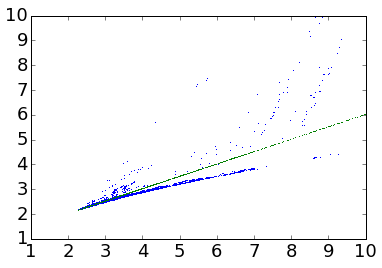

In [68]:
plot(xsc_df.projection_conversion,xsc_df.projection_conversion_x,',')
plot(xsc_df.projection_conversion,xsc_df.projection_conversion*.5+1,',')

xlim(1,10)
ylim(1,10)

(2, 10)

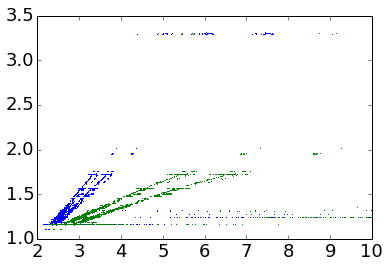

In [70]:
plot(xsc_df.projection_conversion_x,1/np.sin(xsc_df.el_guess),',')
plot(xsc_df.projection_conversion,1/np.sin(xsc_df.el_guess),',')
xlim(2,10)

(2, 10)

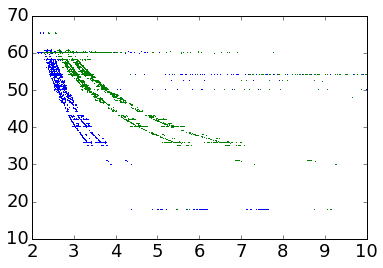

In [72]:
plot(xsc_df.projection_conversion_x,(xsc_df.el_guess)*180/np.pi,',')
plot(xsc_df.projection_conversion,(xsc_df.el_guess)*180/np.pi,',')
xlim(2,10)

(2, 5)

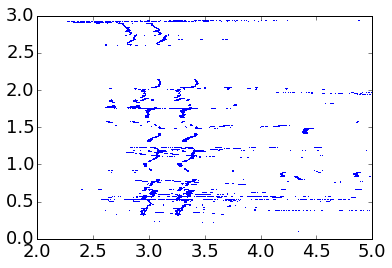

In [66]:
plot(xsc_df.projection_conversion,(xsc_df.lon),',')
xlim(2,5)

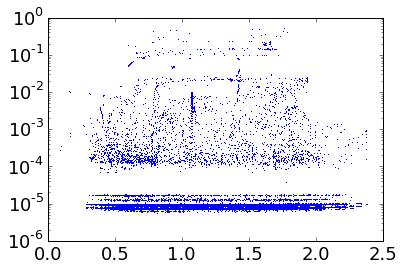

In [10]:
semilogy(xsc_df.distance_from_sun,xsc_df.ra_err,',')

In [11]:
ims = loading.get_images_list(rawpath)

In [12]:
import cloud_spec_fit
reload(cloud_spec_fit)

<module 'cloud_spec_fit' from '/home/gjones/cloud_spec_fit.pyc'>

In [13]:
def row_from_im(im):
    img = loading.get_image_array_from_filename(rawpath,im.which,im.filename,
                                                apply_flat_field_correction=True,adjust_flat_field=False)
    yffts = np.abs(np.fft.rfft((img*np.hamming(1024)[:,None]/np.hamming(1024).sum()),axis=0))**2
    ypsds = yffts.reshape((yffts.shape[0],6,-1)).mean(2)
    xffts = np.abs(np.fft.rfft((img*np.hamming(1536)[None,:]/np.hamming(1536).sum()),axis=1))**2
    #xffts = np.abs(np.fft.rfft((img[:,:1024]*np.hamming(1024)[None,:]/np.hamming(1024).sum()),axis=1))**2
    xpsds = xffts.reshape((4,-1,xffts.shape[1])).mean(1).T*1.5
    kx = np.arange(xpsds.shape[0])/(3.4*1.5)
    ky = np.arange(ypsds.shape[0])/3.4
    fits = cloud_spec_fit.fit_psds(ky[2:-2],ypsds[2:-2,:],direction='y')
    row_dict = dict(xpsds=[xpsds],ypsds = [ypsds],kx=[kx],ky=[ky],which=[im.which],filename=[im.filename],timestamp=[im.timestamp],is_at_float=[im.is_at_float],
                           avg = [img.mean(0,dtype='float64')], rms = [img.std(0)], avg0 = [img.mean(dtype='float64')],
                           rms0 = [img.std()])
    row_dict.update(fits)
    row = pd.DataFrame(row_dict,index=[0])
    return row

In [14]:
pp = joblib.Parallel(n_jobs=30,verbose=5)

In [15]:
rows = pp(joblib.delayed(row_from_im)(x) for x in ims)

[Parallel(n_jobs=30)]: Done   1 out of 9464 | elapsed:    1.6s remaining: 252.9min
[Parallel(n_jobs=30)]: Done 8328 out of 41646 | elapsed: 10.3min remaining: 41.2min
[Parallel(n_jobs=30)]: Done 16658 out of 41646 | elapsed: 19.8min remaining: 29.7min
[Parallel(n_jobs=30)]: Done 24988 out of 41646 | elapsed: 29.4min remaining: 19.6min
[Parallel(n_jobs=30)]: Done 33318 out of 41646 | elapsed: 38.9min remaining:  9.7min
[Parallel(n_jobs=30)]: Done 41646 out of 41646 | elapsed: 47.9min finished


In [16]:
sdf = pd.concat(rows)

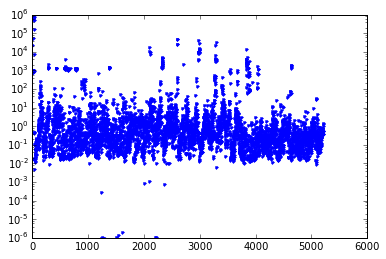

In [196]:
semilogy(sdf.y_whole_image_powlaw_red_scale,'.')

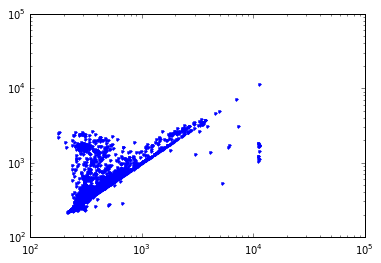

In [220]:
loglog(sdf.y_whole_image_roll_residual,sdf.y_whole_image_powlaw_residual,'.')

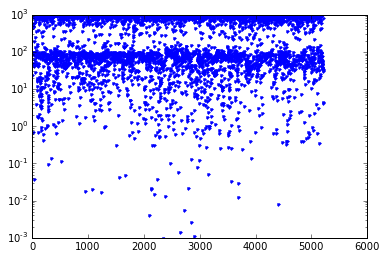

In [229]:
semilogy(sdf.y_whole_image_roll_roll_fc,'.')
#ylim(1e-2,1e-1)

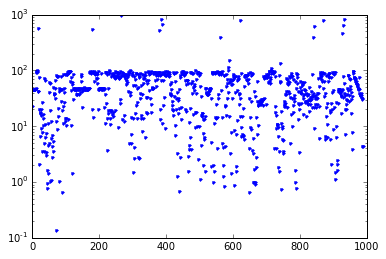

In [253]:
dd = sdf[(sdf.y_whole_image_roll_residual < sdf.y_whole_image_powlaw_residual/1.1)]
semilogy(dd.y_whole_image_roll_roll_fc,'.')

In [49]:
def plot_fits(row,index,do_emcee=True):
    if False:
        fig,axs = plt.subplots(1,6,figsize=(18,6))
        for k in range(6):
            ax = axs.flatten()[k]
            x = row.ky[2:-2]
            ax.loglog(x,row.ypsds[2:-2,k])
            pl = cloud_spec_fit.power_law(x,row.y_segment_powlaw_red_scale[k],row.y_segment_powlaw_red_exp[k]) + row.y_segment_powlaw_white_noise[k]
            ax.loglog(x,pl,lw=2)
            rolloff = cloud_spec_fit.full_model(x,red_scale = row.y_segment_roll_red_scale[k],
                                               red_exp = row.y_segment_roll_red_exp[k],
                                               roll_fc = row.y_segment_roll_roll_fc[k],
                                               roll_exp = row.y_segment_roll_roll_exp[k],
                                               white_noise=row.y_segment_roll_white_noise[k])
            ax.loglog(x,rolloff,'--',lw=2)
    fig,axs = plt.subplots(2,1,figsize=(12,12))
    ax = axs[1]
    x = row.ky[2:-2]
    ax.loglog(x,row.ypsds[2:-2,:].mean(1),'.-')
    pl = cloud_spec_fit.power_law(x,row.y_whole_image_powlaw_red_scale,row.y_whole_image_powlaw_red_exp) + row.y_whole_image_powlaw_white_noise
    ax.loglog(x,pl,':',lw=2)
    rolloff = cloud_spec_fit.full_model(x,red_scale = row.y_whole_image_roll_red_scale,
                                       red_exp = row.y_whole_image_roll_red_exp,
                                       roll_fc = row.y_whole_image_roll_roll_fc,
                                       roll_exp = row.y_whole_image_roll_roll_exp,
                                       white_noise=row.y_whole_image_roll_white_noise)
    ax.loglog(x,rolloff,color='r',lw=1.2)
    ax.loglog(x,row.ypsds[2:-2,:].mean(1)-row.y_whole_image_roll_white_noise)
    rolloff_nn = cloud_spec_fit.full_model(x,red_scale = row.y_whole_image_roll_red_scale,
                                       red_exp = row.y_whole_image_roll_red_exp,
                                       roll_fc = row.y_whole_image_roll_roll_fc,
                                       roll_exp = row.y_whole_image_roll_roll_exp,
                                       white_noise=0)
    ax.loglog(x,rolloff_nn,'--',lw=2)
    
    ax.loglog(x,row.y_whole_image_roll_red_scale*x**(row.y_whole_image_roll_red_exp),':',lw=2)
    ax.text(1e2,row.y_whole_image_roll_red_scale*(1e2)**(row.y_whole_image_roll_red_exp),
           ('$k^{%.2f}$' % row.y_whole_image_roll_red_exp), size='x-large')
    ax.loglog(x,x**(-row.y_whole_image_roll_roll_exp+row.y_whole_image_roll_red_exp),':',lw=2)
    ax.text(2,(2.)**(-row.y_whole_image_roll_roll_exp+row.y_whole_image_roll_red_exp),
           ('$k^{%.2f}$' % (row.y_whole_image_roll_red_exp-row.y_whole_image_roll_roll_exp)), size='x-large')
    
    
    if do_emcee:
        lmres,sampler,labels = cloud_spec_fit.emcee_fit_full(x,row.ypsds[2:-2,:].mean(1))
        for theta in sampler.flatchain[-100:]:
            ax.loglog(x,cloud_spec_fit.full_model_log(x,*theta)-10.**theta[-1],alpha=0.05,color='k')
        blah = corner.corner(sampler.flatchain,labels=labels)
    
    ax.axvline(row.y_whole_image_roll_roll_fc,linestyle='--')
    ax.text(row.y_whole_image_roll_roll_fc,2e-4,('$k_c=%.1f$/km' % row.y_whole_image_roll_roll_fc),size='x-large')
    ax.set_ylim(1e-4,1e2)
    ax.set_xlim(.3,300)
    ax.set_xlabel('wavenumber (cycles/km)')
    ax = axs[0]
    d = loading.get_image_array_from_filename(rawpath,row.which,row.filename,apply_flat_field_correction=True)
    d = leveling.level(d)
    ax.imshow(d,cmap=cm.gray,aspect='auto',origin='lower')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    fig.suptitle('%d: %s' % (index,row.filename))

In [241]:
row.y_whole_image_roll_roll_fc

6.682913122788865

$$P(k) = A k^{\alpha}+n_w$$

$$P(k) = \frac{A k^{\alpha}}{1+(k/k_c)^{\beta}}+n_w$$

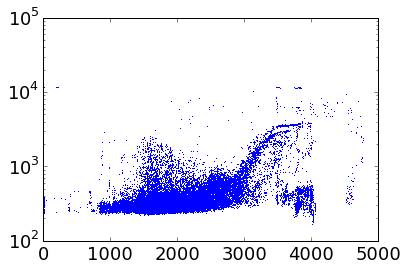

In [26]:
semilogy(mdf.avg0,mdf.y_whole_image_roll_residual,',')

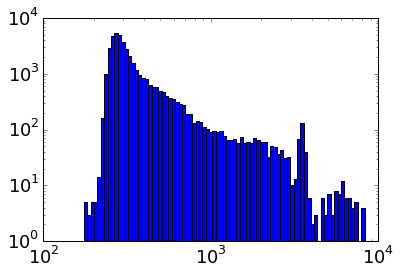

In [27]:
blah = hist(mdf.y_whole_image_roll_residual,bins=np.logspace(2,4,100),log=True)
xscale('log')

In [46]:
import cloud_spec_fit
reload(cloud_spec_fit)
import corner

[[Variables]]
    red_exp:      -5.2730e-10 +/- 0.006705 (1271605496.93%) (init=-2)
    red_scale:     5.98211750 +/- 0.493315 (8.25%) (init= 0.01)
    roll_fc:       1.11396285 +/- 0.064139 (5.76%) (init= 10)
    roll_exp:      2.73993216 +/- 0.117967 (4.31%) (init= 2)
    white_noise:   0.06486638 +/- 0.000107 (0.16%) (init= 1e-09)
[[Correlations]] (unreported correlations are <  0.100)
    C(red_scale, roll_fc)        = -0.984 
    C(red_exp, roll_exp)         = -0.980 
    C(red_exp, roll_fc)          =  0.921 
    C(red_exp, red_scale)        = -0.899 
    C(roll_fc, roll_exp)         = -0.839 
    C(red_scale, roll_exp)       =  0.832 
    C(roll_fc, white_noise)      =  0.222 
    C(red_scale, white_noise)    = -0.204 
    C(red_exp, white_noise)      =  0.179 
    C(roll_exp, white_noise)     = -0.127 
[[Variables]]
    red_exp:      -1.46253054 +/- 0.070651 (4.83%) (init=-2)
    red_scale:     15.6649936 +/- 1.275567 (8.14%) (init= 0.01)
    roll_fc:       11.4411642 +/- 0.857

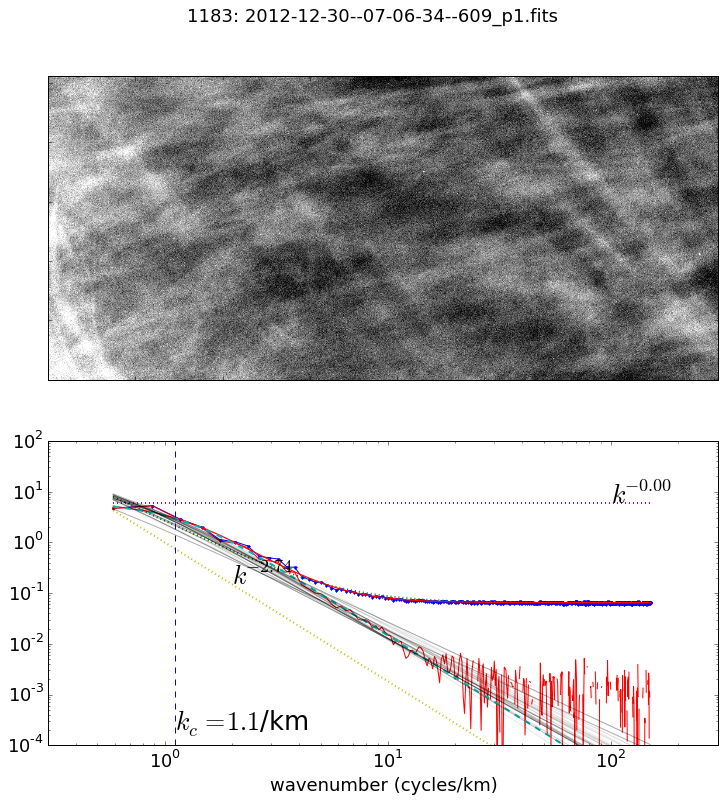

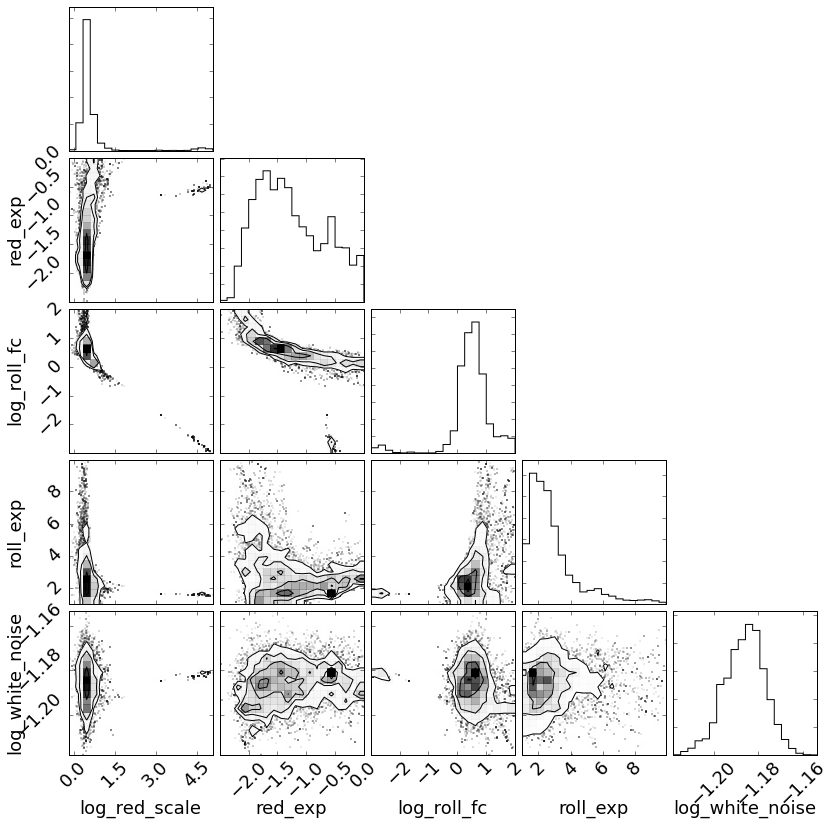

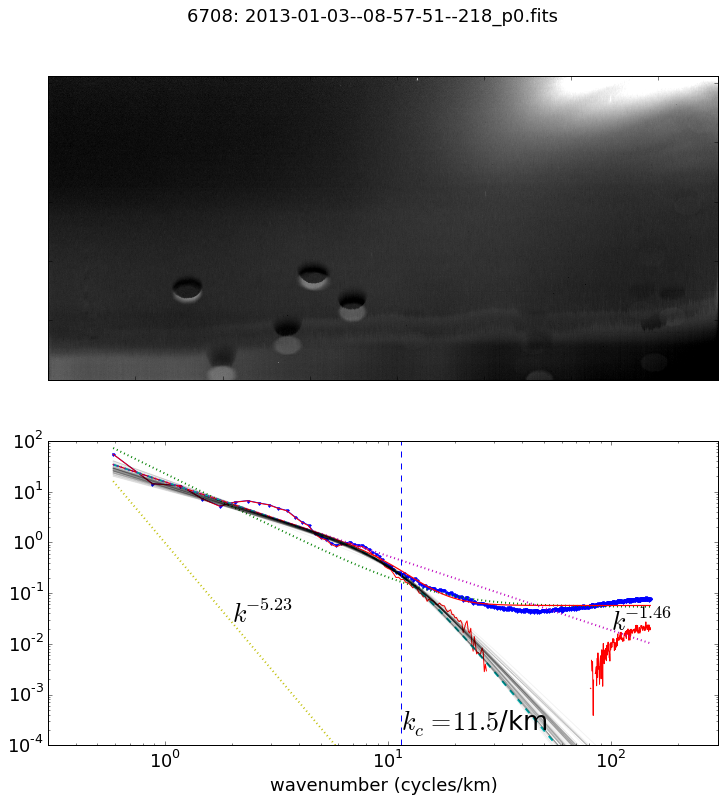

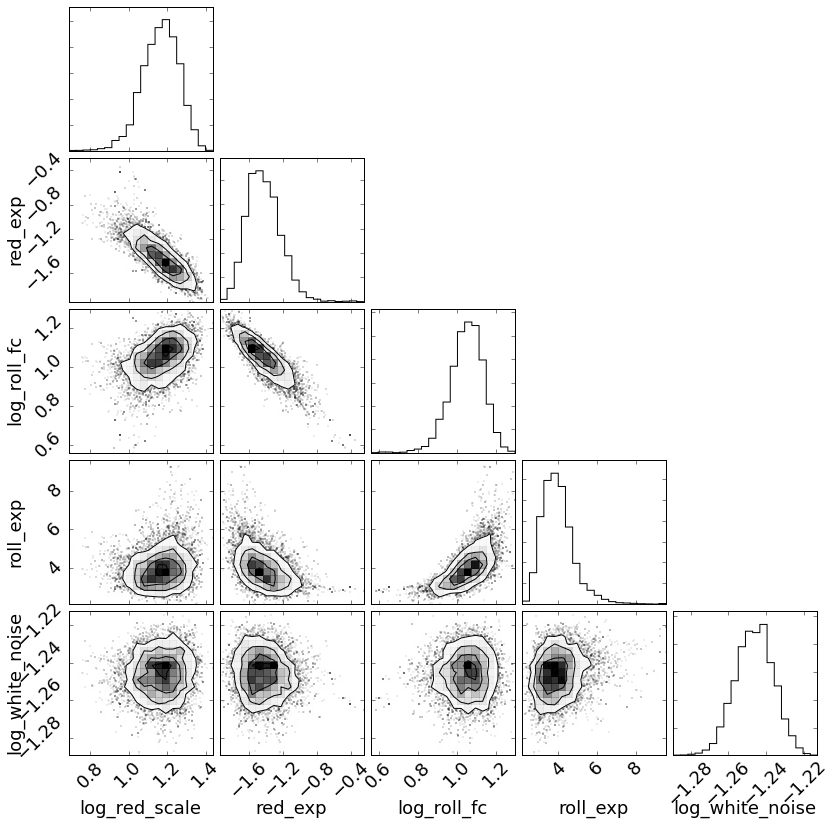

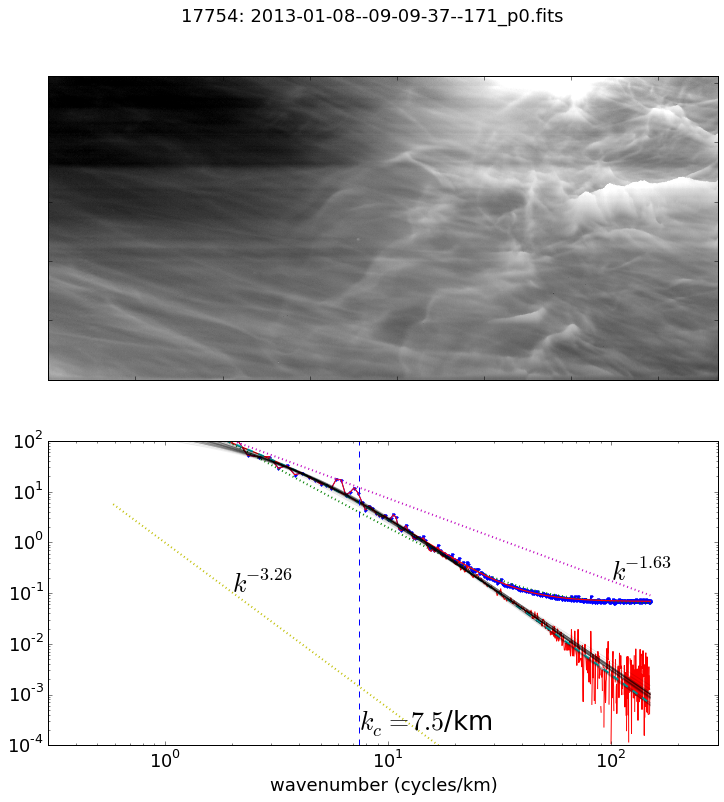

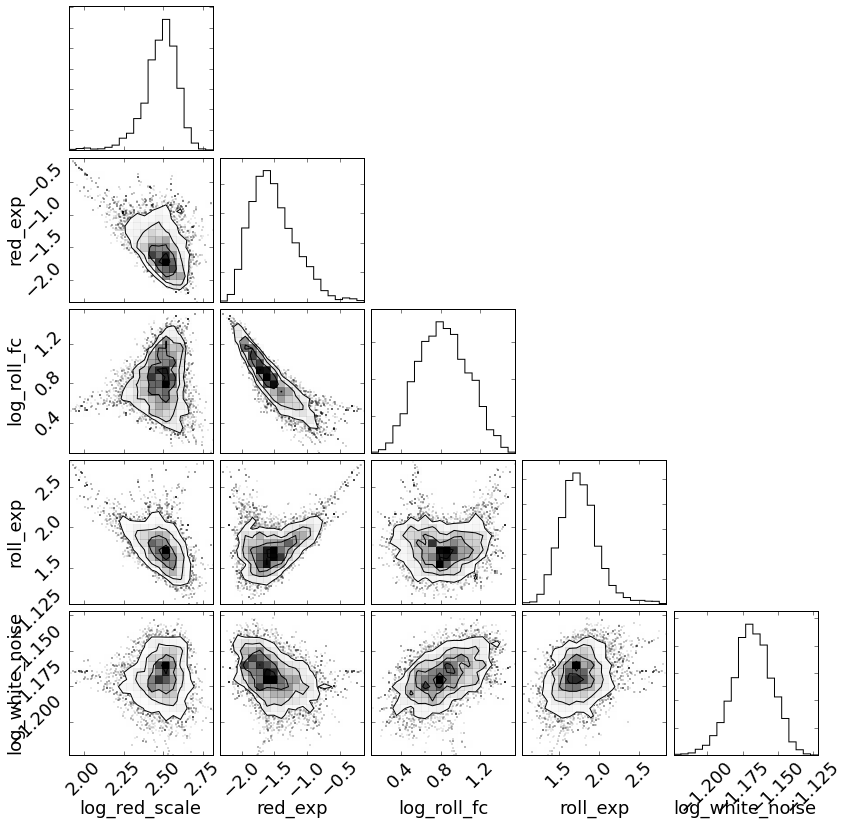

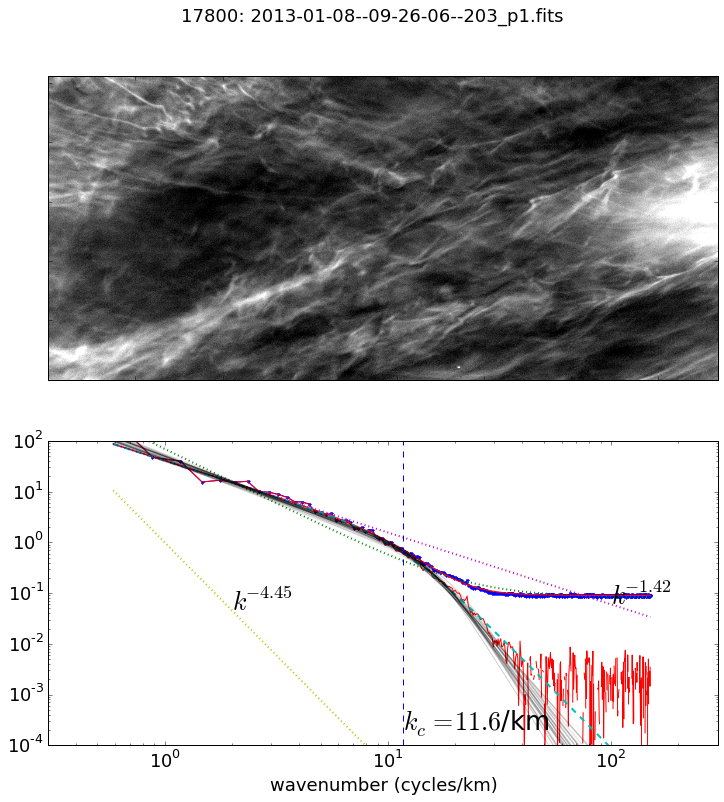

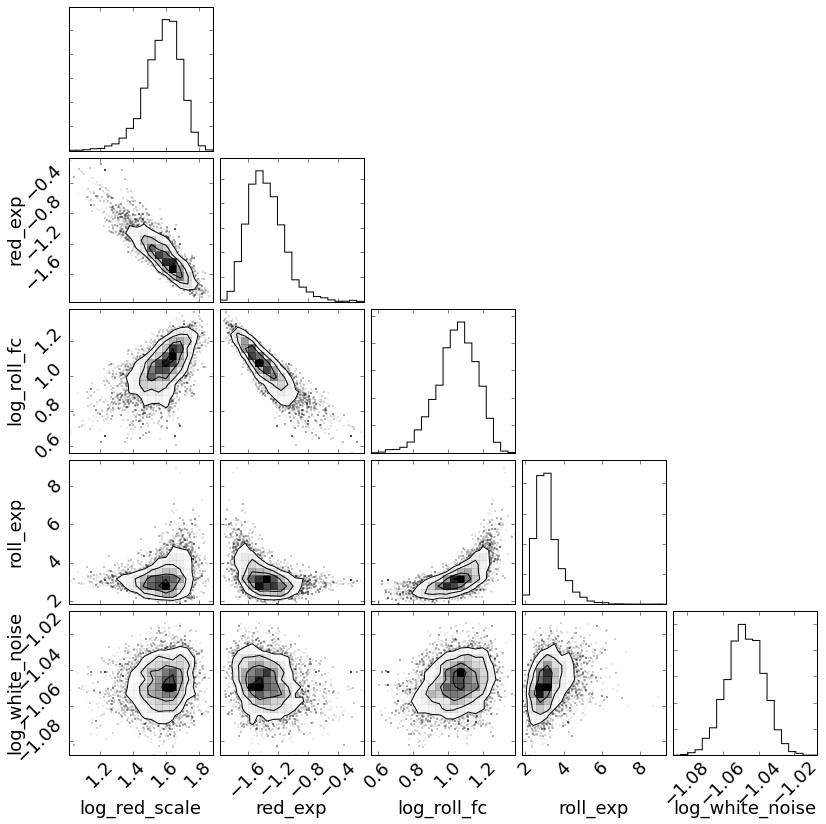

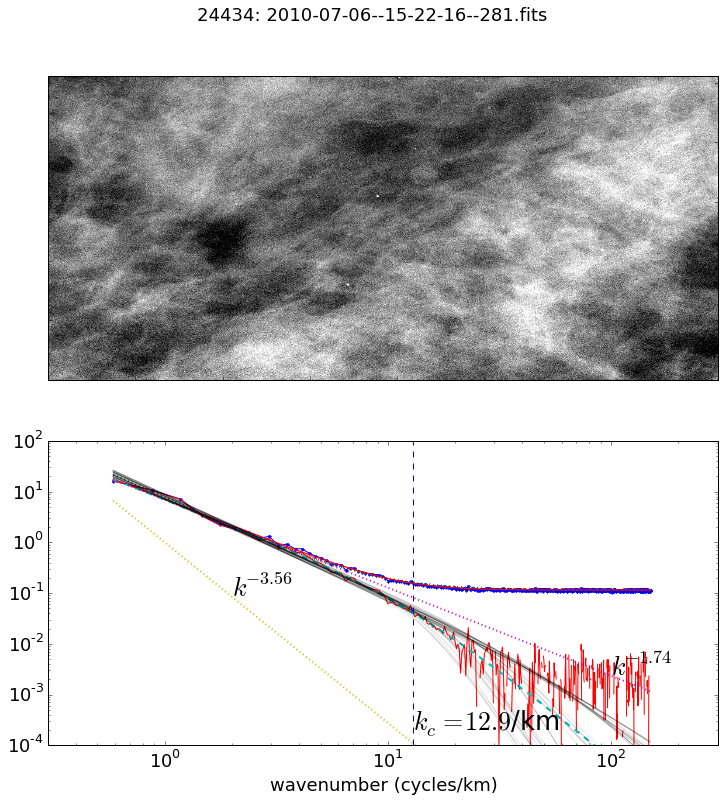

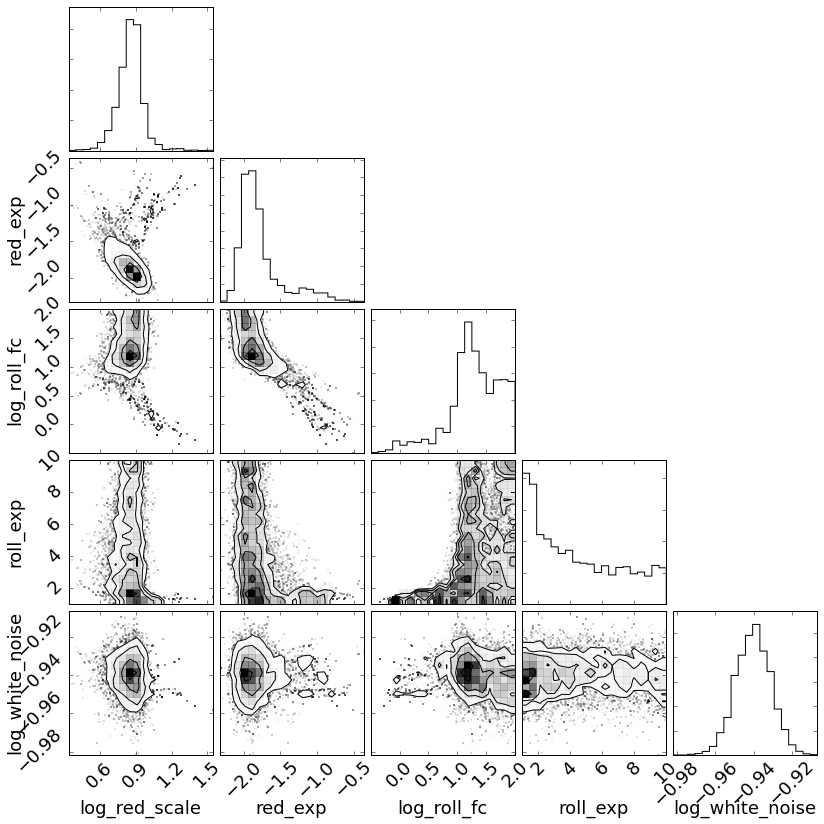

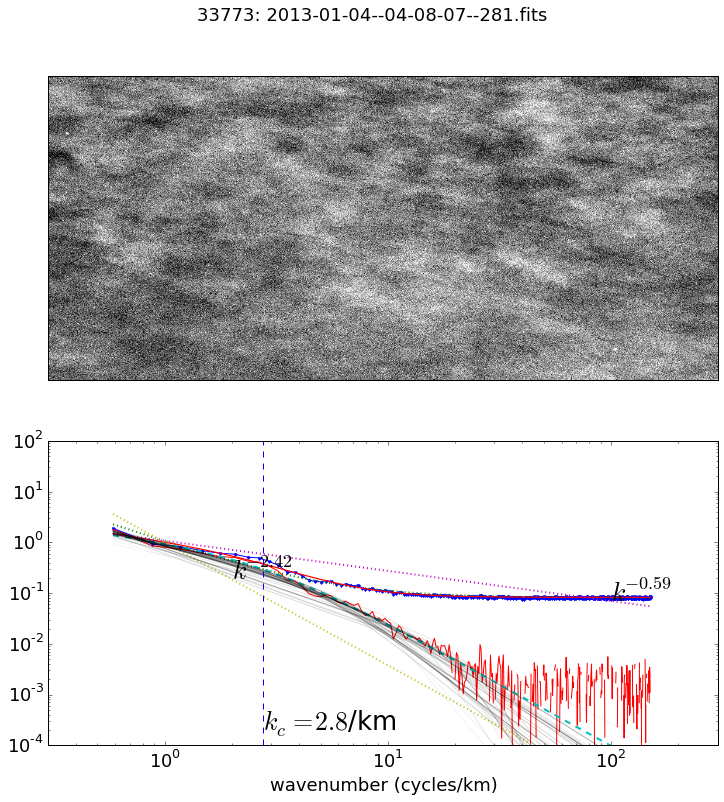

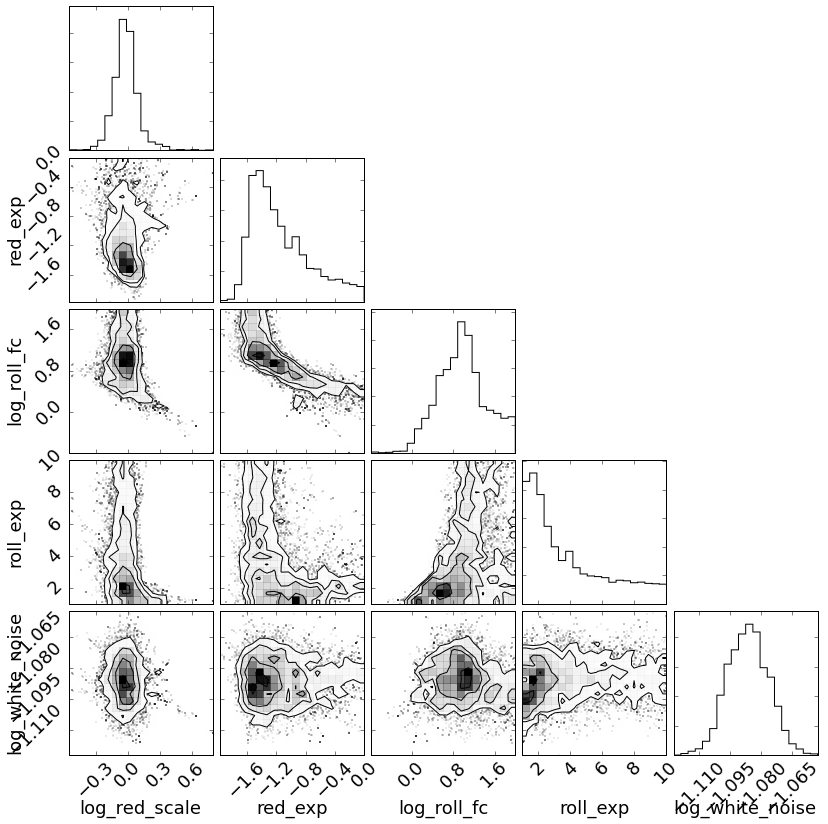

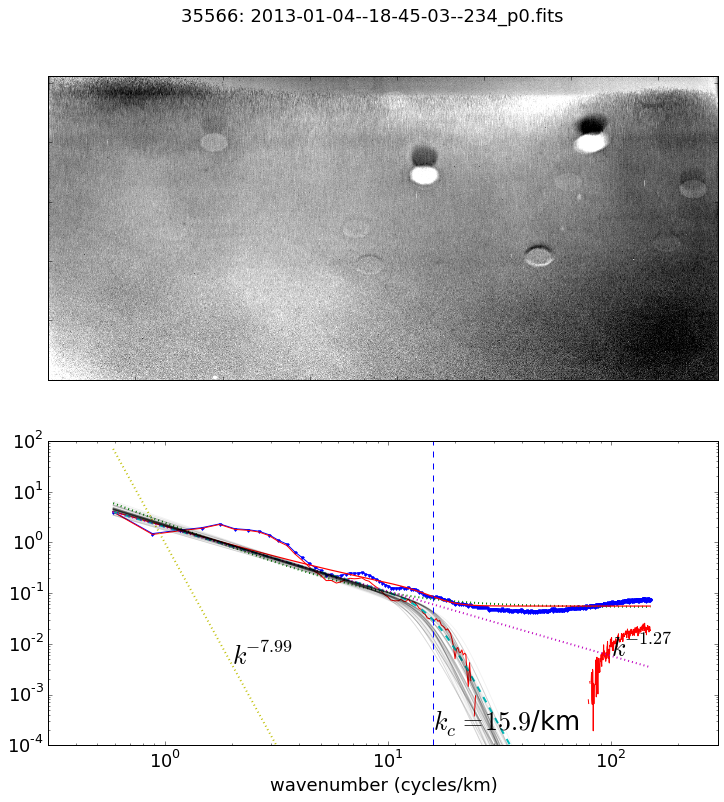

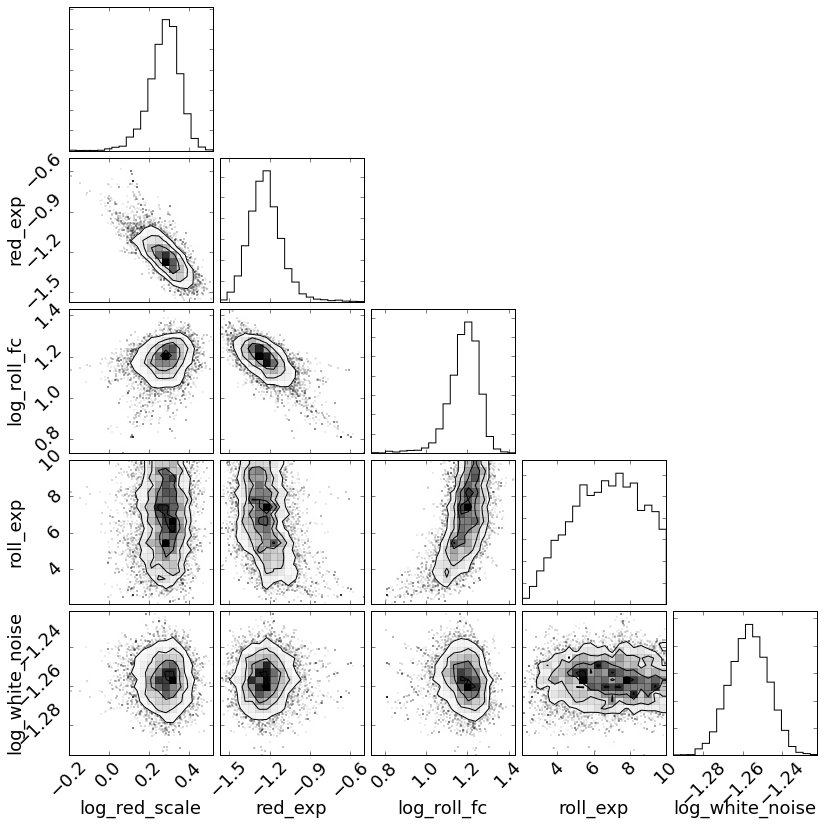

In [50]:
dd = mdf[(mdf.y_whole_image_roll_roll_fc<20) & (mdf.y_whole_image_roll_residual < mdf.y_whole_image_powlaw_residual/1.2)]
random.seed(123)
for k,row in dd.iterrows():
    if random.random()<.005:
        plot_fits(row,k)
        
#        savefig(('/home/gjones/cloud_plots/%s.jpg' % row.filename), bbox_inches='tight')

In [28]:
dd.shape

(1361, 94)

In [17]:
mdf = pd.merge(sdf,xsc_df,on=['which','filename'])

In [132]:
mdf.columns

Index([u'avg', u'avg0', u'filename', u'is_at_float_x', u'kx', u'ky', u'rms',
       u'rms0', u'timestamp_x', u'which', u'xpsds', u'ypsds', u'alt',
       u'az_guess', u'cleanly_matched', u'corner_lats', u'corner_lats_deg',
       u'corner_lons', u'corner_lons_deg', u'day_name', u'dec', u'dec_err',
       u'dec_error', u'dec_guess', u'dirfile_name', u'distance_from_sun',
       u'el_guess', u'end_index', u'filename_base', u'imlat', u'imlon',
       u'iplatescale', u'is_at_float_y', u'lat', u'lat_deg', u'lat_lon_valid',
       u'lon', u'lon_deg', u'lst', u'num_matched', u'part',
       u'projection_conversion', u'projection_conversion_x', u'ra', u'ra_err',
       u'ra_error', u'ra_guess', u'roll', u'roll_error', u'roll_guess',
       u'start_index', u'timestamp_y', u'xfilename', u'xfilename_base'],
      dtype='object')

In [74]:
mdf.shape

(40972, 94)

In [100]:
np.savez('/home/gjones/2015-11-17-xsc-merged-datafame.npz',df = mdf.to_records())

In [73]:
sdf.shape

(41646, 52)

(0.001, 100.0)

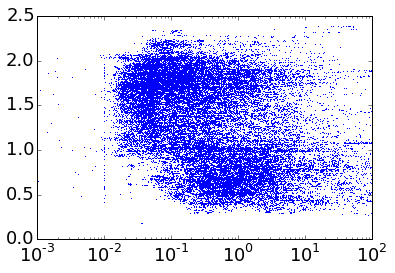

In [24]:
semilogx(mdf.y_whole_image_roll_red_scale,mdf.distance_from_sun,',')
xlim(1e-3,1e2)

In [147]:
mdf.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
            ...
            890, 891, 892, 893, 894, 895, 896, 897, 898, 899],
           dtype='int64', length=900)

In [98]:
mdf.shape

(40972, 94)

In [150]:
mdf.ypsds.iloc[890][2:-2,:].shape

(509, 6)

In [157]:
fits = cloud_spec_fit.fit_psds(mdf.ky.iloc[890][2:-2],mdf.ypsds.iloc[890][2:-2,:],direction='y')

In [158]:
fits

{'y_segment_powlaw_red_exp': [array([-1.74920229, -1.79940134, -1.43158547, -1.4439261 , -2.04098658,
         -1.42042774])],
 'y_segment_powlaw_red_exp_err': [array([ 0.02068482,  0.01622645,  0.02051106,  0.02148279,  0.01486597,
          0.02218273])],
 'y_segment_powlaw_red_scale': [array([  8.8763803 ,   9.53025082,   3.3029191 ,   4.07329047,
          15.05820005,   2.36140028])],
 'y_segment_powlaw_red_scale_err': [array([ 0.38053968,  0.30980668,  0.14175234,  0.19563971,  0.43429483,
          0.09908005])],
 'y_segment_powlaw_white_noise': [array([ 0.06399802,  0.06319031,  0.05964977,  0.0580119 ,  0.06194077,
          0.06102561])],
 'y_segment_powlaw_white_noise_err': [array([ 0.00057602,  0.00042777,  0.00067676,  0.00075581,  0.00031038,
          0.00052121])],
 'y_segment_roll_red_exp': [array([-1.18316485, -1.4549028 , -0.63184879, -1.44395448, -1.81781102,
         -1.4161308 ])],
 'y_segment_roll_red_exp_err': [array([ 0.06824196,  0.0448852 ,  0.06131177,  0.02

In [32]:
im = ims[1000]
d = loading.get_image_array_from_filename(rawpath,im.which,im.filename,
                                                apply_flat_field_correction=True,adjust_flat_field=False)

In [34]:
d.shape

(1024, 1536)

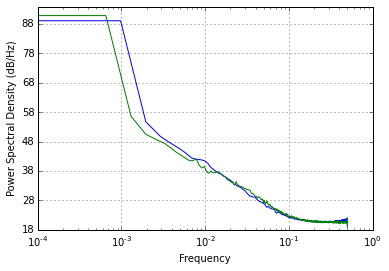

In [47]:
blah = psd(d.flatten(),NFFT=1024,Fs=1.0)
blah = psd(d.T.flatten(),NFFT=1536,Fs=1.0)
xscale('log')

In [35]:
d2 = d.reshape((4,256,1536))

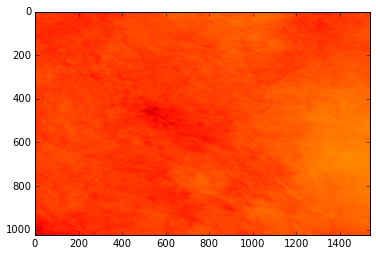

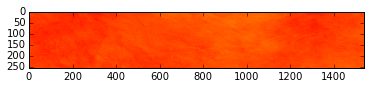

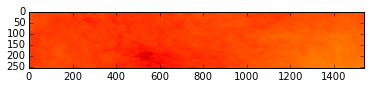

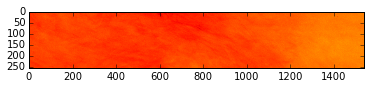

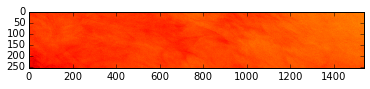

In [43]:
imshow(d/d.max())
clim(0,1)
for k in range(4):
    figure()
    imshow(d2[k]/(1.*d.max()))
    clim(0,1)

In [88]:
np.sqrt(3)

1.7320508075688772

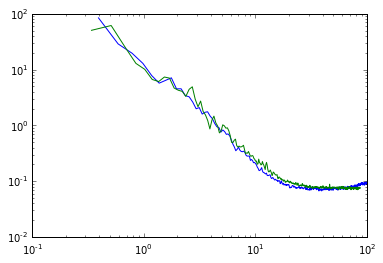

In [90]:
loglog(r1.kx.iloc[0][2:-2],r1.xpsds.iloc[0][2:-2].mean(1))
loglog(r1.ky.iloc[0][2:-2]/np.sqrt(3),r1.ypsds.iloc[0][2:-2].mean(1))


In [10]:
data = []
tic = time.time()
for im in ims[:10]:
    img = loading.get_image_array_from_filename(rawpath,im.which,im.filename,
                                                apply_flat_field_correction=True,adjust_flat_field=False)
    ffts = np.abs(np.fft.rfft((img),axis=0)/1024)**2
    psds = ffts.reshape((ffts.shape[0],6,-1)).mean(2)
    wffts = np.abs(np.fft.rfft((img*np.hamming(1024)[:,None]/np.hamming(1024).sum()),axis=0)/1024)**2
    wpsds = wffts.reshape((wffts.shape[0],6,-1)).mean(2)
    
    row = pd.DataFrame(dict(psds=[psds],wpsds = [wpsds],which=[im.which],filename=[im.filename],timestamp=[im.timestamp],is_at_float=[im.is_at_float],
                           avg = [img.mean(0,dtype='float64')], rms = [img.std(0)], avg0 = [img.mean(dtype='float64')],
                           rms0 = [img.std()]),index=[0])
    data.append(row)
    timeper = (time.time()-tic)/len(data)
    total = timeper*len(ims)
    finish = tic + total
    print "\rtime per",timeper,"total",(total/3600.),"finish at",time.ctime(finish),

time per 0.278588700294 total 3.22280694791 finish at Thu Oct 29 14:24:48 2015
